In [73]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from adjustText import adjust_text
import re
from scripts.analysis_helper_functions import helper_functions_SBML_analysis as hf
from source.load_sbml.sbml_load import *
from source.load_sbml.sbml_model import SBMLModel
import seaborn as sns
from scipy.stats import zscore

## Figure out what seperates the learned and initial parameters the most
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [74]:





def cosine_similarity(true_params,optimized_params):
    """"Calculates the cosine similarity (in log space) between true and optimized parameters"""


    keys = set(true_params.keys()).union(set(optimized_params.keys()))
    
    # Create vectors
    true_params = np.array([true_params.get(key, 0) for key in keys])
    optimized_params = np.array([optimized_params.get(key, 0) for key in keys])

    true_params=np.log2(true_params)
    optimized_params=np.log2(optimized_params)

    cos_sim = np.dot(true_params, optimized_params)/(np.linalg.norm(true_params)*np.linalg.norm(optimized_params))
    return cos_sim

In [92]:
model_names=os.listdir("results/EXP1_initialization_bounds_lhs_V2")

results_dir="results/EXP1_initialization_bounds_lhs_V2/"

model_names=["Ray2013"]
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs_V2/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=hf.retrieve_convergence_results(results_dir,file_list)
    # model_success_dict[model_name]=hf.retrieve_success_rate(loss_dfs,model_name)

15:53:20,658 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
15:53:20,659 - source.load_sbml.sbml_model - INFO - Model loaded.
15:53:20,659 - source.load_sbml.sbml_model - INFO -  number of species: 6
15:53:20,660 - source.load_sbml.sbml_model - INFO -  number of reactions: 6
15:53:20,660 - source.load_sbml.sbml_model - INFO -  number of global parameters: 0
15:53:20,660 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
15:53:20,660 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 6
15:53:20,661 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 0
15:53:20,709 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
15:53:20,710 - source.load_sbml.sbml_model - INFO - Model loaded.
15:53:20,710 - source.load_sbml.sbml_model - INFO -  number of species: 6
15:53:20,711 - source.load_sbml.sbml_model - INFO -  number of reactions: 6
15:53:20,711 - source.load_sbml.sbml_mo

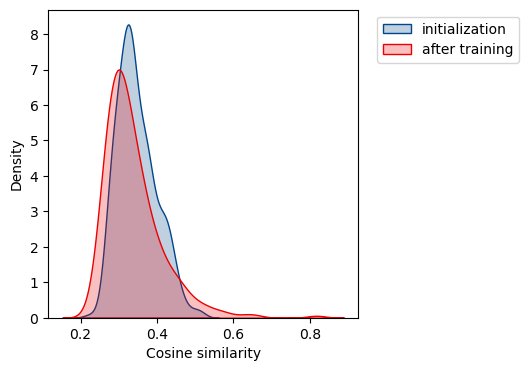

In [98]:






bounds=['bounds_100.csv']

colors=['#00468BFF',"#ED0000FF","#925E9FFF","#AD002AFF","#ADB6B6FF"]
# for k,bound in enumerate(bounds):





runs=['run_1','run_2','run_3']

for bound in bounds:
    fig,ax=plt.subplots(figsize=(4,4))
    dist_init=[]
    dist_training=[]
    dist_succesful=[]
    for runid in runs:

        model_name="Ray2013"



        #retrieve true parameters
        filepath = ("models/sbml_models/working_models/"+model_name+".xml")
        model=SBMLModel(file_path=filepath)
        params = get_global_parameters(model.model)
        true_params = {**model.local_params, **params}

        max_dist=[]




        file_name_trained=f"{model_name}_parameters_id_lhs_N=100{runid}{bound}"
        file_name_init=f"parameter_initializations/{model_name}/{model_name}_parameterset_id_lhs_N=100{runid}{bound}"
        file_name_loss=f"{model_name}_losses_id_lhs_N=100run_1{bound}"


        # retrieve parameters from initializations
        parameter_initializations=pd.read_csv(file_name_init,index_col=0).T

        loss_df=loss_dfs[file_name_loss]
        params_df=params_dfs[file_name_trained]

        #subset succesful parameterization (loss<1e-3)
        # succesful_parameters=loss_df.iloc[:,np.where(np.abs(loss_df)<=0.001)[1]].columns.to_list()
        # succesful_params=params_df[succesful_parameters]

        #calculate distance between initialization and true params
        
        for k,colname in enumerate(parameter_initializations.columns):
            dist=cosine_similarity(true_params,parameter_initializations[k].to_dict())
            dist_init.append(dist)



        for k,colname in enumerate(params_df.columns):
            dist=cosine_similarity(true_params,params_df[colname].to_dict())
            dist_training.append(dist)


        # for k,colname in enumerate(succesful_params.columns):
        #     dist=cosine_similarity(true_params,succesful_params[colname].to_dict())
        #     dist_succesful.append(dist)

    dist_init=np.array(dist_init)
    dist_training=np.array(dist_training)
    dist_succesful=np.array(dist_succesful)

    sns.kdeplot(dist_init,fill=True,label="initialization",color="#00468BFF")
    sns.kdeplot(dist_training,fill=True,label="after training",color="#ED0000FF")
    sns.kdeplot(dist_succesful,fill=True,label="succesfull",color="#925E9FFF")
    ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
    plt.xlabel("Cosine similarity")
    # plt.xlim(0,1)
    # plt.xlabel("Log Euclidean distance")
    plt.show()

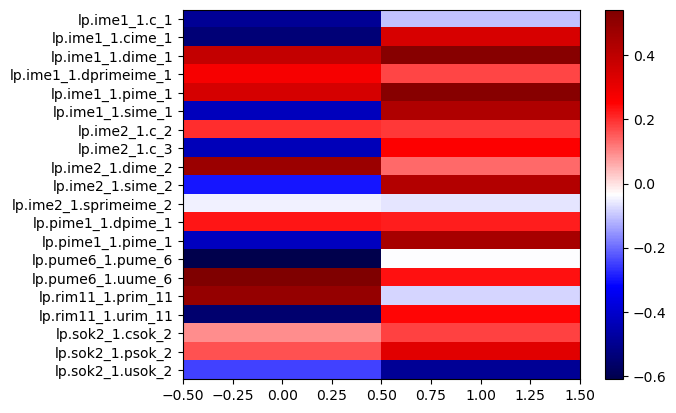

Text(0, 0.5, 'PC2')

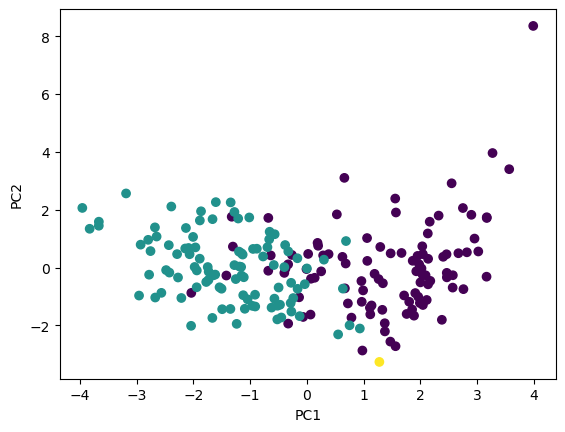

In [99]:


labels=np.zeros(np.shape(parameter_initializations)[1])
labels2=np.ones(np.shape(params_df)[1])

labels3=np.array([2])
labels=np.concatenate([labels,labels2,labels3])

# +[0]*np.shape(parameter_initializations)[1]
params=pd.concat([params_df,parameter_initializations,pd.Series(true_params)],axis=1).T


lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = lda.fit(params, labels).transform(params)
# sns.kdeplot(X_r2)
pca = PCA(n_components=2)
scaler=StandardScaler()
scaled_data=scaler.fit_transform(params)

X_embedded=pca.fit_transform(scaled_data)



# fig,ax=plt.subplots(figsize=)
plt.imshow(pca.components_.T*np.sqrt(pca.explained_variance_),aspect="auto",cmap="seismic")
plt.yticks(np.arange(0,len(params.columns.to_list())),params.columns.to_list())
plt.colorbar()
plt.show()


plt.scatter(X_embedded[:,0],X_embedded[:,1],c=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")



In [115]:
loadings=pca.components_.T*np.sqrt(pca.explained_variance_)[0]
# plt.imshow(np.abs(loadings))
sorted_loadings=np.argsort(np.abs(loadings[:,0]))[::-1][0:5]
params_df=params_df.iloc[:,sorted_loadings]


# dist_init=[]        
# for k,colname in enumerate(parameter_initializations.T.columns):
#     dist=cosine_similarity(true_params,parameter_initializations[k].to_dict())
#     dist_init.append(dist)


# dist_training=[]     
# for k,colname in enumerate(params_df_filtered.T.columns):
#     dist=cosine_similarity(true_params,params_df[colname].to_dict())
#     dist_training.append(dist)


In [138]:
trained_params_filtered=trained_params=params_dfs[file_name_trained].T.iloc[:,sorted_loadings]
initial_params_filtered=parameter_initializations.T.iloc[:,sorted_loadings]


dist_init=[]        
for k,colname in enumerate(initial_params_filtered.T.columns):

    dist=cosine_similarity(true_params,initial_params_filtered.iloc[k,:].to_dict())
    print(initial_params_filtered.iloc[k,:].to_dict())
    print(true_params)
    dist_init.append(dist)


dist_training=[]     
for k,colname in enumerate(trained_params_filtered.T.columns):

    dist=cosine_similarity(true_params,trained_params_filtered.iloc[k,:].to_dict())
    dist_training.append(dist)


# dist_init=np.array(dist_init)
# dist_training=np.array(dist_training)
# # dist_succesful=np.array(dist_succesful)

# sns.kdeplot(dist_init,fill=True,label="initialization",color="#00468BFF")
# sns.kdeplot(dist_training,fill=True,label="after training",color="#ED0000FF")
# # sns.kdeplot(dist_succesful,fill=True,label="succesfull",color="#925E9FFF")
# ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# plt.xlabel("Cosine similarity")
# # plt.xlim(0,1)
# # plt.xlabel("Log Euclidean distance")
# plt.show()

{'lp.pime1_1.dpime_1': 10.699852542708577, 'lp.ime2_1.c_3': 189.94194505356296, 'lp.pime1_1.pime_1': 120.86117009194284, 'lp.rim11_1.urim_11': 2.142306968677391, 'lp.rim11_1.prim_11': 0.8834965931072182}
{'lp.rim11_1.prim_11': 0.01, 'lp.rim11_1.urim_11': 0.1, 'lp.pume6_1.pume_6': 0.3, 'lp.pume6_1.uume_6': 0.01, 'lp.sok2_1.csok_2': 0.05, 'lp.sok2_1.psok_2': 0.7, 'lp.sok2_1.usok_2': 1.0, 'lp.ime1_1.c_1': 0.01, 'lp.ime1_1.cime_1': 0.01, 'lp.ime1_1.dime_1': 1.0, 'lp.ime1_1.dprimeime_1': 1.0, 'lp.ime1_1.pime_1': 2.0, 'lp.ime1_1.sime_1': 10.0, 'lp.pime1_1.dpime_1': 1.0, 'lp.pime1_1.pime_1': 2.0, 'lp.ime2_1.c_2': 1.4, 'lp.ime2_1.c_3': 2.0, 'lp.ime2_1.dime_2': 8.0, 'lp.ime2_1.sime_2': 10.0, 'lp.ime2_1.sprimeime_2': 3.0}
{'lp.pime1_1.dpime_1': 84.82582502728926, 'lp.ime2_1.c_3': 142.3511634321222, 'lp.pime1_1.pime_1': 163.05735556763972, 'lp.rim11_1.urim_11': 7.550523707565342, 'lp.rim11_1.prim_11': 0.4646526468866524}
{'lp.rim11_1.prim_11': 0.01, 'lp.rim11_1.urim_11': 0.1, 'lp.pume6_1.pume_6':

/tmp/ipykernel_147813/926726630.py:12: RuntimeWarning: divide by zero encountered in log2
  optimized_params=np.log2(optimized_params)
/tmp/ipykernel_147813/926726630.py:12: RuntimeWarning: divide by zero encountered in log2
  optimized_params=np.log2(optimized_params)
